# GAMA-09 master catalogue

This notebook presents the merge of the various pristine catalogues to produce HELP mater catalogue on GAMA-09.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
44f1ae0 (Thu Nov 30 18:27:54 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
cfhtlens = Table.read("{}/CFHTLENS.fits".format(TMP_DIR))
cfhtls = Table.read("{}/CFHTLS.fits".format(TMP_DIR))
decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))
hsc = Table.read("{}/HSC-SSP.fits".format(TMP_DIR))
kids = Table.read("{}/KIDS.fits".format(TMP_DIR))
ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))
las = Table.read("{}/UKIDSS-LAS.fits".format(TMP_DIR))
vhs = Table.read("{}/VISTA-VHS.fits".format(TMP_DIR))
viking = Table.read("{}/VISTA-VIKING.fits".format(TMP_DIR))

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones: CFHTLenS, CFHTLS, DECaLS, HSC, KIDS, PanSTARRS, UKIDSS-LAS, VISTA-VHS, and VISTA-VIKING.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### CFHTLenS

In [5]:
master_catalogue = cfhtlens
master_catalogue['cfhtlens_ra'].name = 'ra'
master_catalogue['cfhtlens_dec'].name = 'dec'

### Add CFHTLS

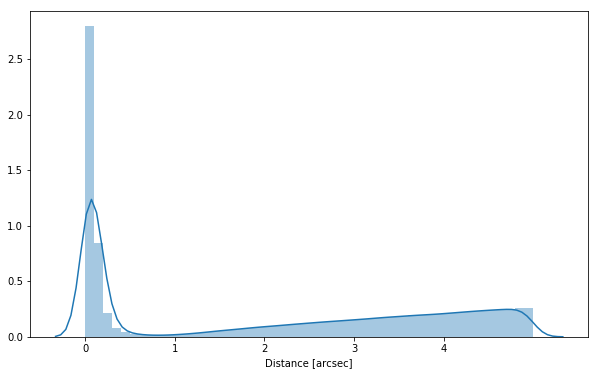

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(cfhtls['cfhtls_ra'], cfhtls['cfhtls_dec'])
)

In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, cfhtls, "cfhtls_ra", "cfhtls_dec", radius=0.8*u.arcsec)

### Add DECaLS

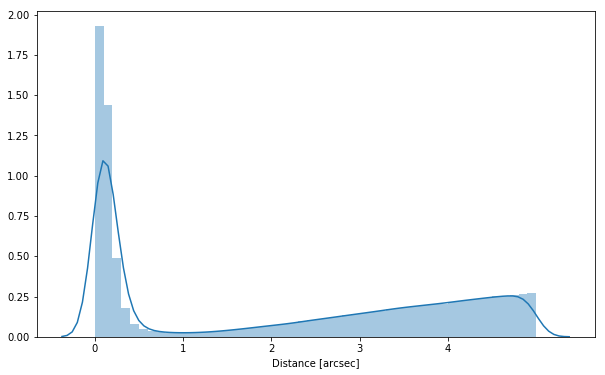

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(decals['decals_ra'], decals['decals_dec'])
)

In [9]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, decals, "decals_ra", "decals_dec", radius=0.8*u.arcsec)

### Add HSC-PSS

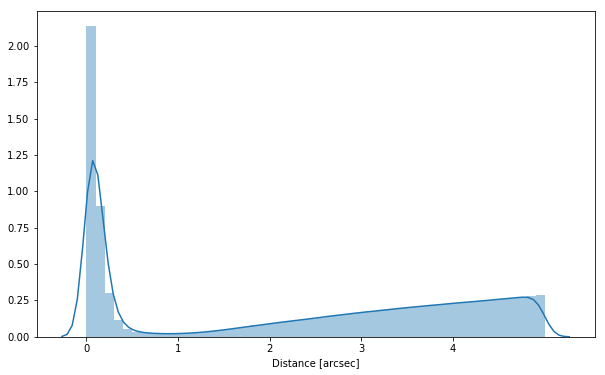

In [10]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(hsc['hsc_ra'], hsc['hsc_dec'])
)

In [11]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, hsc, "hsc_ra", "hsc_dec", radius=0.8*u.arcsec)

### Add KIDS

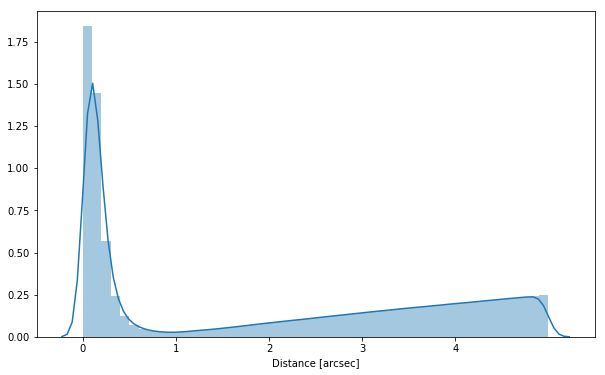

In [12]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(kids['kids_ra'], kids['kids_dec'])
)

In [13]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, kids, "kids_ra", "kids_dec", radius=0.8*u.arcsec)

### Add PanSTARRS

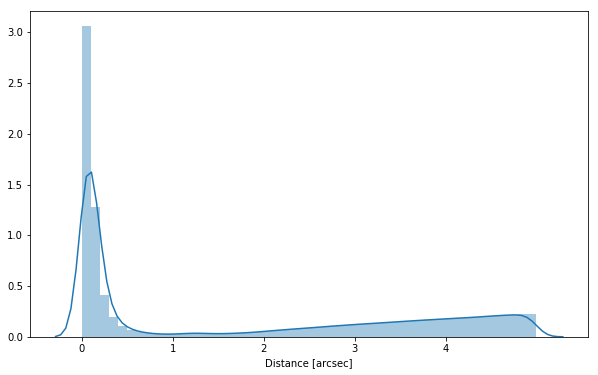

In [14]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(ps1['ps1_ra'], ps1['ps1_dec'])
)

In [15]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, ps1, "ps1_ra", "ps1_dec", radius=0.8*u.arcsec)

### Add UKIDSS LAS

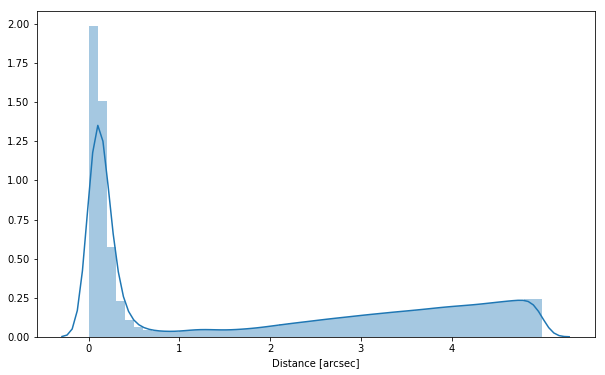

In [16]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(las['las_ra'], las['las_dec'])
)

In [17]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, las, "las_ra", "las_dec", radius=0.8*u.arcsec)

### Add VHS

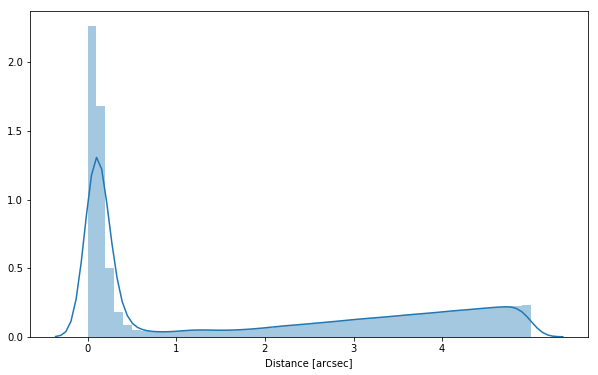

In [18]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(vhs['vhs_ra'], vhs['vhs_dec'])
)

In [19]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, vhs, "vhs_ra", "vhs_dec", radius=1.*u.arcsec)

### Add VIKING

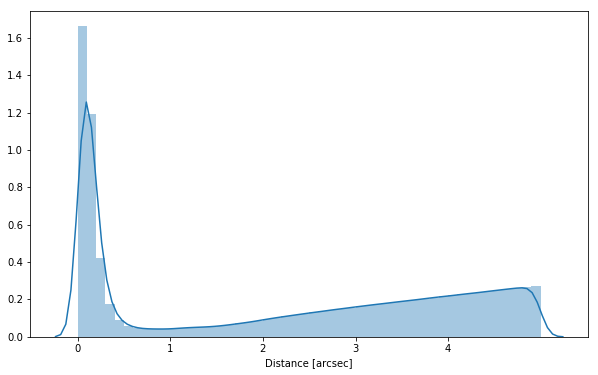

In [20]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(viking['viking_ra'], viking['viking_dec'])
)

In [21]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, viking, "viking_ra", "viking_dec", radius=1.*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [22]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [23]:
master_catalogue[:10].show_in_notebook()

idx,cfhtlens_id,ra,dec,cfhtlens_stellarity,m_cfhtlens_u,merr_cfhtlens_u,m_cfhtlens_g,merr_cfhtlens_g,m_cfhtlens_r,merr_cfhtlens_r,m_cfhtlens_i,merr_cfhtlens_i,m_cfhtlens_z,merr_cfhtlens_z,f_cfhtlens_u,ferr_cfhtlens_u,flag_cfhtlens_u,f_cfhtlens_g,ferr_cfhtlens_g,flag_cfhtlens_g,f_cfhtlens_r,ferr_cfhtlens_r,flag_cfhtlens_r,f_cfhtlens_i,ferr_cfhtlens_i,flag_cfhtlens_i,f_cfhtlens_z,ferr_cfhtlens_z,flag_cfhtlens_z,cfhtlens_flag_cleaned,cfhtlens_flag_gaia,flag_merged,cfhtls_id,cfhtls_stellarity,m_cfhtls_u,merr_cfhtls_u,m_cfhtls_g,merr_cfhtls_g,m_cfhtls_r,merr_cfhtls_r,m_cfhtls_i,merr_cfhtls_i,m_cfhtls_z,merr_cfhtls_z,m_ap_cfhtls_u,merr_ap_cfhtls_u,m_ap_cfhtls_g,merr_ap_cfhtls_g,m_ap_cfhtls_r,merr_ap_cfhtls_r,m_ap_cfhtls_i,merr_ap_cfhtls_i,m_ap_cfhtls_z,merr_ap_cfhtls_z,f_cfhtls_u,ferr_cfhtls_u,flag_cfhtls_u,f_cfhtls_g,ferr_cfhtls_g,flag_cfhtls_g,f_cfhtls_r,ferr_cfhtls_r,flag_cfhtls_r,f_cfhtls_i,ferr_cfhtls_i,flag_cfhtls_i,f_cfhtls_z,ferr_cfhtls_z,flag_cfhtls_z,f_ap_cfhtls_u,ferr_ap_cfhtls_u,f_ap_cfhtls_g,ferr_ap_cfhtls_g,f_ap_cfhtls_r,ferr_ap_cfhtls_r,f_ap_cfhtls_i,ferr_ap_cfhtls_i,f_ap_cfhtls_z,ferr_ap_cfhtls_z,cfhtls_flag_cleaned,cfhtls_flag_gaia,decals_id,f_decam_g,f_decam_r,f_decam_z,ferr_decam_g,ferr_decam_r,ferr_decam_z,f_ap_decam_g,f_ap_decam_r,f_ap_decam_z,ferr_ap_decam_g,ferr_ap_decam_r,ferr_ap_decam_z,m_decam_g,merr_decam_g,flag_decam_g,m_decam_r,merr_decam_r,flag_decam_r,m_decam_z,merr_decam_z,flag_decam_z,m_ap_decam_g,merr_ap_decam_g,m_ap_decam_r,merr_ap_decam_r,m_ap_decam_z,merr_ap_decam_z,decals_stellarity,decals_flag_cleaned,decals_flag_gaia,hsc_id,m_ap_suprime_g,merr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_r,merr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_i,merr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_z,merr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_y,merr_ap_suprime_y,m_suprime_y,merr_suprime_y,hsc_stellarity,f_ap_suprime_g,ferr_ap_suprime_g,f_suprime_g,ferr_suprime_g,flag_suprime_g,f_ap_suprime_r,ferr_ap_suprime_r,f_suprime_r,ferr_suprime_r,flag_suprime_r,f_ap_suprime_i,ferr_ap_suprime_i,f_suprime_i,ferr_suprime_i,flag_suprime_i,f_ap_suprime_z,ferr_ap_suprime_z,f_suprime_z,ferr_suprime_z,flag_suprime_z,f_ap_suprime_y,ferr_ap_suprime_y,f_suprime_y,ferr_suprime_y,flag_suprime_y,hsc_flag_cleaned,hsc_flag_gaia,kids_id,kids_stellarity,m_kids_u,merr_kids_u,m_kids_g,merr_kids_g,m_kids_r,merr_kids_r,m_kids_i,merr_kids_i,f_ap_kids_u,ferr_ap_kids_u,f_ap_kids_g,ferr_ap_kids_g,f_ap_kids_r,ferr_ap_kids_r,f_ap_kids_i,ferr_ap_kids_i,f_kids_u,ferr_kids_u,flag_kids_u,f_kids_g,ferr_kids_g,flag_kids_g,f_kids_r,ferr_kids_r,flag_kids_r,f_kids_i,ferr_kids_i,flag_kids_i,m_ap_kids_u,merr_ap_kids_u,m_ap_kids_g,merr_ap_kids_g,m_ap_kids_r,merr_ap_kids_r,m_ap_kids_i,merr_ap_kids_i,kids_flag_cleaned,kids_flag_gaia,ps1_id,m_ap_gpc1_g,merr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_r,merr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_i,merr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_z,merr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_y,merr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,f_ap_gpc1_g,ferr_ap_gpc1_g,f_gpc1_g,ferr_gpc1_g,flag_gpc1_g,f_ap_gpc1_r,ferr_ap_gpc1_r,f_gpc1_r,ferr_gpc1_r,flag_gpc1_r,f_ap_gpc1_i,ferr_ap_gpc1_i,f_gpc1_i,ferr_gpc1_i,flag_gpc1_i,f_ap_gpc1_z,ferr_ap_gpc1_z,f_gpc1_z,ferr_gpc1_z,flag_gpc1_z,f_ap_gpc1_y,ferr_ap_gpc1_y,f_gpc1_y,ferr_gpc1_y,flag_gpc1_y,ps1_flag_cleaned,ps1_flag_gaia,las_id,m_ukidss_y,merr_ukidss_y,m_ap_ukidss_y,merr_ap_ukidss_y,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,m_ap_ukidss_h,merr_ap_ukidss_h,m_ukidss_h,merr_ukidss_h,m_ap_ukidss_k,merr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,las_stellarity,f_ukidss_y,ferr_ukidss_y,flag_ukidss_y,f_ap_ukidss_y,ferr_ap_ukidss_y,f_ukidss_j,ferr_ukidss_j,flag_ukidss_j,f_ap_ukidss_j,ferr_ap_ukidss_j,f_ap_ukidss_h,ferr_ap_ukidss_h,f_ukidss_h,ferr_ukidss_h,flag_ukidss_h,f_ap_ukidss_k,ferr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,flag_ukidss_k,las_flag_cleaned,las_flag_gaia,vhs_id,vhs_stellarity,m_vhs_y,merr_vhs_y,m_ap_vhs_y,merr_ap_vhs_y,m_vhs

## III - Merging flags and stellarity

Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process.  We merge these flags in a single one.

In [24]:
flag_cleaned_columns = [column for column in master_catalogue.colnames
                        if 'flag_cleaned' in column]

flag_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_cleaned_columns:
    flag_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_column, name="flag_cleaned"))
master_catalogue.remove_columns(flag_cleaned_columns)

Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely).  We merge these flags taking the highest value.

In [25]:
flag_gaia_columns = [column for column in master_catalogue.colnames
                     if 'flag_gaia' in column]

master_catalogue.add_column(Column(
    data=np.max([master_catalogue[column] for column in flag_gaia_columns], axis=0),
    name="flag_gaia"
))
master_catalogue.remove_columns(flag_gaia_columns)

Each prisitine catalogue may contain one or several stellarity columns indicating the probability (0 to 1) of each source being a star.  We merge these columns taking the highest value.

In [26]:
stellarity_columns = [column for column in master_catalogue.colnames
                      if 'stellarity' in column]

print(", ".join(stellarity_columns))

cfhtlens_stellarity, cfhtls_stellarity, decals_stellarity, hsc_stellarity, kids_stellarity, las_stellarity, vhs_stellarity, viking_stellarity


In [27]:
master_catalogue.add_column(Column(
    data=np.nanmax([master_catalogue[column] for column in stellarity_columns], axis=0),
    name="stellarity"
))
master_catalogue.remove_columns(stellarity_columns)

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:343: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


## IV - Adding E(B-V) column

In [28]:
master_catalogue.add_column(
    ebv(master_catalogue['ra'], master_catalogue['dec'])
)

## V - Adding HELP unique identifiers and field columns

In [29]:
master_catalogue.add_column(Column(gen_help_id(master_catalogue['ra'], master_catalogue['dec']),
                                   name="help_id"))
master_catalogue.add_column(Column(np.full(len(master_catalogue), "GAMA-09", dtype='<U18'),
                                   name="field"))

In [30]:
# Check that the HELP Ids are unique
if len(master_catalogue) != len(np.unique(master_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

OK!


## VI - Cross-matching with the spec-z catalogue

In [31]:
specz = Table.read("../../dmu23/dmu23_GAMA-09/data/HELP-SPECZ_GAMA-09_20170202-2.fits")

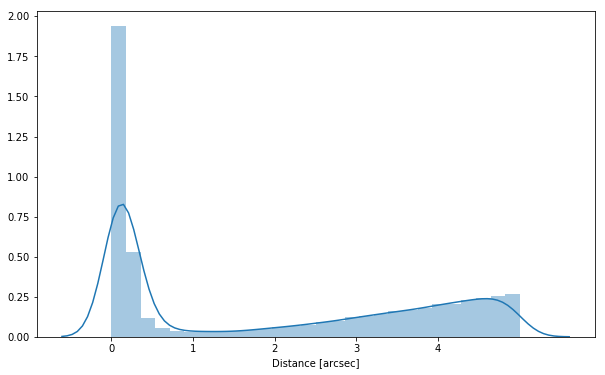

In [32]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(specz['ra'], specz['dec'])
)

In [33]:
master_catalogue = specz_merge(master_catalogue, specz, radius=.8 * u.arcsec)

## VII - Choosing between multiple values for the same filter

Both CFHTLenS and CFHTLS, and VISTA-VIKING and VISTA-VHS have measurements from the same camera and filters. We wish to choose the superior measurement where both are present.

### VII.a CFHTLenS and CFHTLS
CFHTLS is optimised for deep photometry so we take that for 

In [34]:
megacam_origin = Table()
megacam_origin.add_column(master_catalogue['help_id'])

In [35]:
megacam_bands = ['u','g','r','i','z'] # Lowercase naming convention (k is Ks)
for band in megacam_bands:
    print('For Megacam band ' + band + ':')
    # Megacam total flux 
    has_cfhtls = ~np.isnan(master_catalogue['f_cfhtls_' + band])
    has_cfhtlens = ~np.isnan(master_catalogue['f_cfhtlens_' + band])
    has_both = has_cfhtls & has_cfhtlens

    print("{} sources with CFHTLS flux".format(np.sum(has_cfhtls)))
    print("{} sources with CFHTLenS flux".format(np.sum(has_cfhtlens)))
    print("{} sources with CFHTLS and CFHTLenS flux".format(np.sum(has_both)))


    use_cfhtls = has_cfhtls 
    use_cfhtlens = has_cfhtlens & ~has_both

    print("{} sources for which we use CFHTLS".format(np.sum(use_cfhtls)))
    print("{} sources for which we use CFHTLenS".format(np.sum(use_cfhtlens)))

    f_megacam = np.full(len(master_catalogue), np.nan)
    f_megacam[use_cfhtls] = master_catalogue['f_cfhtls_' + band][use_cfhtls]
    f_megacam[use_cfhtlens] = master_catalogue['f_cfhtlens_' + band][use_cfhtlens]

    ferr_megacam = np.full(len(master_catalogue), np.nan)
    ferr_megacam[use_cfhtls] = master_catalogue['ferr_cfhtls_' + band][use_cfhtls]
    ferr_megacam[use_cfhtlens] = master_catalogue['ferr_cfhtlens_' + band][use_cfhtlens]
    
    m_megacam = np.full(len(master_catalogue), np.nan)
    m_megacam[use_cfhtls] = master_catalogue['m_cfhtls_' + band][use_cfhtls]
    m_megacam[use_cfhtlens] = master_catalogue['m_cfhtlens_' + band][use_cfhtlens]

    merr_megacam = np.full(len(master_catalogue), np.nan)
    merr_megacam[use_cfhtls] = master_catalogue['merr_cfhtls_' + band][use_cfhtls]
    merr_megacam[use_cfhtlens] = master_catalogue['merr_cfhtlens_' + band][use_cfhtlens]

    flag_megacam = np.full(len(master_catalogue), False, dtype=bool)
    flag_megacam[use_cfhtls] = master_catalogue['flag_cfhtls_' + band][use_cfhtls]
    flag_megacam[use_cfhtlens] = master_catalogue['flag_cfhtlens_' + band][use_cfhtlens]

    master_catalogue.add_column(Column(data=f_megacam, name="f_megacam_" + band))
    master_catalogue.add_column(Column(data=ferr_megacam, name="ferr_megacam_" + band))
    master_catalogue.add_column(Column(data=m_megacam, name="m_megacam_" + band))
    master_catalogue.add_column(Column(data=merr_megacam, name="merr_megacam_" + band))
    master_catalogue.add_column(Column(data=flag_megacam, name="flag_megacam_" + band))

    master_catalogue.remove_columns(['f_cfhtls_' + band, 
                                     'f_cfhtlens_' + band, 
                                     'ferr_cfhtls_' + band,
                                     'ferr_cfhtlens_' + band, 
                                     'm_cfhtls_' + band, 
                                     'm_cfhtlens_' + band, 
                                     'merr_cfhtls_' + band,
                                     'merr_cfhtlens_' + band,
                                     'flag_cfhtls_' + band, 
                                     'flag_cfhtlens_' + band])

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_cfhtls] = "CFHTLS"
    origin[use_cfhtlens] = "CFHTLenS"
    
    megacam_origin.add_column(Column(data=origin, name= 'f_megacam_' + band ))
    
    
    
    # There are no Megacam aperture flux in CFHTLenS
    

For Megacam band u:
898336 sources with CFHTLS flux
403760 sources with CFHTLenS flux
386292 sources with CFHTLS and CFHTLenS flux
898336 sources for which we use CFHTLS
17468 sources for which we use CFHTLenS
For Megacam band g:
968859 sources with CFHTLS flux
506111 sources with CFHTLenS flux
486700 sources with CFHTLS and CFHTLenS flux
968859 sources for which we use CFHTLS
19411 sources for which we use CFHTLenS
For Megacam band r:
984214 sources with CFHTLS flux
509786 sources with CFHTLenS flux
489579 sources with CFHTLS and CFHTLenS flux
984214 sources for which we use CFHTLS
20207 sources for which we use CFHTLenS
For Megacam band i:
959749 sources with CFHTLS flux
529203 sources with CFHTLenS flux
498878 sources with CFHTLS and CFHTLenS flux
959749 sources for which we use CFHTLS
30325 sources for which we use CFHTLenS
For Megacam band z:
846472 sources with CFHTLS flux
421512 sources with CFHTLenS flux
396727 sources with CFHTLS and CFHTLenS flux
846472 sources for which we u

In [36]:
#Aperture flux only in CFHTLS
for band in megacam_bands:
    master_catalogue['f_ap_cfhtls_' + band].name = 'f_ap_megacam_' + band
    master_catalogue['ferr_ap_cfhtls_' + band].name = 'ferr_ap_megacam_' + band
    master_catalogue['m_ap_cfhtls_' + band].name = 'm_ap_megacam_' + band
    master_catalogue['merr_ap_cfhtls_' + band].name = 'merr_ap_megacam_' + band


In [37]:
megacam_origin.write("{}/gama-09_megacam_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX))

### VII.b VISTA-VIKING and VISTA-VHS
VIKING is deeper than VHS so we take the VIKING photometry if available.

In [38]:
vista_origin = Table()
vista_origin.add_column(master_catalogue['help_id'])

In [39]:
vista_bands = ['y','j','h','k'] # Lowercase naming convention (k is Ks)
for band in vista_bands:
    print('For VISTA band ' + band + ':')
    # VISTA total flux 
    has_viking = ~np.isnan(master_catalogue['f_viking_' + band])
    has_vhs = ~np.isnan(master_catalogue['f_vhs_' + band])
    has_both = has_viking & has_vhs

    print("{} sources with VIKING flux".format(np.sum(has_viking)))
    print("{} sources with VHS flux".format(np.sum(has_vhs)))
    print("{} sources with VIKING and VHS flux".format(np.sum(has_both)))


    use_viking = has_viking 
    use_vhs = has_vhs & ~has_both

    print("{} sources for which we use VIKING".format(np.sum(use_viking)))
    print("{} sources for which we use VHS".format(np.sum(use_vhs)))

    f_vista = np.full(len(master_catalogue), np.nan)
    f_vista[use_viking] = master_catalogue['f_viking_' + band][use_viking]
    f_vista[use_vhs] = master_catalogue['f_vhs_' + band][use_vhs]

    ferr_vista = np.full(len(master_catalogue), np.nan)
    ferr_vista[use_viking] = master_catalogue['ferr_viking_' + band][use_viking]
    ferr_vista[use_vhs] = master_catalogue['ferr_vhs_' + band][use_vhs]
    
    m_vista = np.full(len(master_catalogue), np.nan)
    m_vista[use_viking] = master_catalogue['m_viking_' + band][use_viking]
    m_vista[use_vhs] = master_catalogue['m_vhs_' + band][use_vhs]

    merr_vista = np.full(len(master_catalogue), np.nan)
    merr_vista[use_viking] = master_catalogue['merr_viking_' + band][use_viking]
    merr_vista[use_vhs] = master_catalogue['merr_vhs_' + band][use_vhs]

    flag_vista = np.full(len(master_catalogue), False, dtype=bool)
    flag_vista[use_viking] = master_catalogue['flag_viking_' + band][use_viking]
    flag_vista[use_vhs] = master_catalogue['flag_vhs_' + band][use_vhs]

    master_catalogue.add_column(Column(data=f_vista, name="f_vista_" + band))
    master_catalogue.add_column(Column(data=ferr_vista, name="ferr_vista_" + band))
    master_catalogue.add_column(Column(data=m_vista, name="m_vista_" + band))
    master_catalogue.add_column(Column(data=merr_vista, name="merr_vista_" + band))
    master_catalogue.add_column(Column(data=flag_vista, name="flag_vista_" + band))

    master_catalogue.remove_columns(['f_viking_' + band, 
                                     'f_vhs_' + band, 
                                     'ferr_viking_' + band,
                                     'ferr_vhs_' + band, 
                                     'm_viking_' + band, 
                                     'm_vhs_' + band, 
                                     'merr_viking_' + band,
                                     'merr_vhs_' + band,
                                     'flag_viking_' + band, 
                                     'flag_vhs_' + band])

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_viking] = "VIKING"
    origin[use_vhs] = "VHS"
    
    vista_origin.add_column(Column(data=origin, name= 'f_vista_' + band ))
    
    
    
    # VISTA Aperture flux
    has_ap_viking = ~np.isnan(master_catalogue['f_ap_viking_' + band])
    has_ap_vhs = ~np.isnan(master_catalogue['f_ap_vhs_' + band])
    has_ap_both = has_ap_viking & has_ap_vhs

    print("{} sources with VIKING aperture flux".format(np.sum(has_ap_viking)))
    print("{} sources with VHS aperture flux".format(np.sum(has_ap_vhs)))
    print("{} sources with VIKING and VHS aperture flux".format(np.sum(has_ap_both)))


    use_ap_viking = has_ap_viking 
    use_ap_vhs = has_ap_vhs & ~has_ap_both

    print("{} sources for which we use VIKING aperture fluxes".format(np.sum(use_ap_viking)))
    print("{} sources for which we use VHS aperture fluxes".format(np.sum(use_ap_vhs)))

    f_ap_vista = np.full(len(master_catalogue), np.nan)
    f_ap_vista[use_ap_viking] = master_catalogue['f_ap_viking_' + band][use_ap_viking]
    f_ap_vista[use_ap_vhs] = master_catalogue['f_ap_vhs_' + band][use_ap_vhs]

    ferr_ap_vista = np.full(len(master_catalogue), np.nan)
    ferr_ap_vista[use_ap_viking] = master_catalogue['ferr_ap_viking_' + band][use_ap_viking]
    ferr_ap_vista[use_ap_vhs] = master_catalogue['ferr_ap_vhs_' + band][use_ap_vhs]
    
    m_ap_vista = np.full(len(master_catalogue), np.nan)
    m_ap_vista[use_ap_viking] = master_catalogue['m_ap_viking_' + band][use_ap_viking]
    m_ap_vista[use_ap_vhs] = master_catalogue['m_ap_vhs_' + band][use_ap_vhs]

    merr_ap_vista = np.full(len(master_catalogue), np.nan)
    merr_ap_vista[use_ap_viking] = master_catalogue['merr_ap_viking_' + band][use_ap_viking]
    merr_ap_vista[use_ap_vhs] = master_catalogue['merr_ap_vhs_' + band][use_ap_vhs]


    master_catalogue.add_column(Column(data=f_ap_vista, name="f_ap_vista_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_vista, name="ferr_ap_vista_" + band))
    master_catalogue.add_column(Column(data=m_ap_vista, name="m_ap_vista_" + band))
    master_catalogue.add_column(Column(data=merr_vista, name="merr_ap_vista_" + band))


    master_catalogue.remove_columns(['f_ap_viking_' + band, 
                                     'f_ap_vhs_' + band, 
                                     'ferr_ap_viking_' + band,
                                     'ferr_ap_vhs_' + band,
                                     'm_ap_viking_' + band, 
                                     'm_ap_vhs_' + band, 
                                     'merr_ap_viking_' + band,
                                     'merr_ap_vhs_' + band])

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_viking] = "VIKING"
    origin_ap[use_ap_vhs] = "VHS"
    
    vista_origin.add_column(Column(data=origin_ap, name= 'f_ap_vista_' + band ))
                  

For VISTA band y:
1386617 sources with VIKING flux
157730 sources with VHS flux
65293 sources with VIKING and VHS flux
1386617 sources for which we use VIKING
92437 sources for which we use VHS
1386533 sources with VIKING aperture flux
157725 sources with VHS aperture flux
65293 sources with VIKING and VHS aperture flux
1386533 sources for which we use VIKING aperture fluxes
92432 sources for which we use VHS aperture fluxes
For VISTA band j:
1614888 sources with VIKING flux
431419 sources with VHS flux
278769 sources with VIKING and VHS flux
1614888 sources for which we use VIKING
152650 sources for which we use VHS
1614759 sources with VIKING aperture flux
431399 sources with VHS aperture flux
278747 sources with VIKING and VHS aperture flux
1614759 sources for which we use VIKING aperture fluxes
152652 sources for which we use VHS aperture fluxes
For VISTA band h:
1616502 sources with VIKING flux
122508 sources with VHS flux
77750 sources with VIKING and VHS flux
1616502 sources for

In [40]:
      
#Z band only in viking
               
master_catalogue['f_ap_viking_z'].name = 'f_ap_vista_z'
master_catalogue['ferr_ap_viking_z'].name = 'ferr_ap_vista_z'
master_catalogue['f_viking_z'].name = 'f_vista_z'
master_catalogue['ferr_viking_z'].name = 'ferr_vista_z'
master_catalogue['m_ap_viking_z'].name = 'm_ap_vista_z'
master_catalogue['merr_ap_viking_z'].name = 'merr_ap_vista_z'
master_catalogue['m_viking_z'].name = 'm_vista_z'
master_catalogue['merr_viking_z'].name = 'merr_vista_z'
master_catalogue['flag_viking_z'].name = 'flag_vista_z'

In [41]:
vista_origin.write("{}/gama-09_vista_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX))

## VIII.a Wavelength domain coverage

We add a binary `flag_optnir_obs` indicating that a source was observed in a given wavelength domain:

- 1 for observation in optical;
- 2 for observation in near-infrared;
- 4 for observation in mid-infrared (IRAC).

It's an integer binary flag, so a source observed both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: The observation flag is based on the creation of multi-order coverage maps from the catalogues, this may not be accurate, especially on the edges of the coverage.*

*Note 2: Being on the observation coverage does not mean having fluxes in that wavelength domain. For sources observed in one domain but having no flux in it, one must take into consideration de different depths in the catalogue we are using.*

In [42]:
cfhtlens_moc = MOC(filename="../../dmu0/dmu0_CFHTLenS/data/CFHTLenS_GAMA-09_MOC.fits")
cfhtls_moc = MOC(filename="../../dmu0/dmu0_CFHTLS/data/CFHTLS-WIDE_GAMA-09_MOC.fits")
decals_moc = MOC(filename="../../dmu0/dmu0_DECaLS/data/DECaLS_GAMA-09_MOC.fits")
hsc_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_wide_GAMA-09_MOC.fits")
kids_moc = MOC(filename="../../dmu0/dmu0_KIDS/data/KIDS-DR3_GAMA-09_MOC.fits")
ps1_moc = MOC(filename="../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_GAMA-09_MOC.fits")
las_moc = MOC(filename="../../dmu0/dmu0_UKIDSS-LAS/data/UKIDSS-LAS_GAMA-09_MOC.fits")
vhs_moc = MOC(filename="../../dmu0/dmu0_VISTA-VHS/data/VHS_GAMA-09_MOC.fits")
viking_moc = MOC(filename="../../dmu0/dmu0_VISTA-VIKING/data/VIKING_GAMA-09_MOC.fits")

In [43]:
was_observed_optical = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    cfhtlens_moc + cfhtls_moc + decals_moc + hsc_moc + ps1_moc) 

was_observed_nir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    las_moc + vhs_moc + viking_moc
)

was_observed_mir = np.zeros(len(master_catalogue), dtype=bool)

#was_observed_mir = inMoc(
#    master_catalogue['ra'], master_catalogue['dec'],   
#)

In [44]:
master_catalogue.add_column(
    Column(
        1 * was_observed_optical + 2 * was_observed_nir + 4 * was_observed_mir,
        name="flag_optnir_obs")
)

## VIII.b Wavelength domain detection

We add a binary `flag_optnir_det` indicating that a source was detected in a given wavelength domain:

- 1 for detection in optical;
- 2 for detection in near-infrared;
- 4 for detection in mid-infrared (IRAC).

It's an integer binary flag, so a source detected both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: We use the total flux columns to know if the source has flux, in some catalogues, we may have aperture flux and no total flux.*

To get rid of artefacts (chip edges, star flares, etc.) we consider that a source is detected in one wavelength domain when it has a flux value in **at least two bands**. That means that good sources will be excluded from this flag when they are on the coverage of only one band.

In [45]:
# SpARCS is a catalogue of sources detected in r (with fluxes measured at 
# this prior position in the other bands).  Thus, we are only using the r
# CFHT band.
# Check to use catalogue flags from HSC and PanSTARRS.
nb_optical_flux = (
    1 * ~np.isnan(master_catalogue['f_megacam_u']) +
    1 * ~np.isnan(master_catalogue['f_megacam_g']) +
    1 * ~np.isnan(master_catalogue['f_megacam_r']) +
    1 * ~np.isnan(master_catalogue['f_megacam_i']) +
    1 * ~np.isnan(master_catalogue['f_megacam_z']) +
    1 * ~np.isnan(master_catalogue['f_suprime_g']) +
    1 * ~np.isnan(master_catalogue['f_suprime_r']) +
    1 * ~np.isnan(master_catalogue['f_suprime_i']) +
    1 * ~np.isnan(master_catalogue['f_suprime_z']) +
    1 * ~np.isnan(master_catalogue['f_suprime_y']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_g']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_r']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_i']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_z']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_y']) +
    1 * ~np.isnan(master_catalogue['f_decam_g']) +
    1 * ~np.isnan(master_catalogue['f_decam_r']) +
    1 * ~np.isnan(master_catalogue['f_decam_z']) +
    1 * ~np.isnan(master_catalogue['f_kids_u']) +
    1 * ~np.isnan(master_catalogue['f_kids_g']) +
    1 * ~np.isnan(master_catalogue['f_kids_r']) +
    1 * ~np.isnan(master_catalogue['f_kids_i']) 
)

nb_nir_flux = (
    1 * ~np.isnan(master_catalogue['f_ukidss_y']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_j']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_h']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_k']) +
    1 * ~np.isnan(master_catalogue['f_vista_z']) +
    1 * ~np.isnan(master_catalogue['f_vista_y']) +
    1 * ~np.isnan(master_catalogue['f_vista_h']) +
    1 * ~np.isnan(master_catalogue['f_vista_j']) +
    1 * ~np.isnan(master_catalogue['f_vista_k'])
)

nb_mir_flux = np.zeros(len(master_catalogue), dtype=bool)

In [46]:
has_optical_flux = nb_optical_flux >= 2
has_nir_flux = nb_nir_flux >= 2
has_mir_flux = nb_mir_flux >= 2

master_catalogue.add_column(
    Column(
        1 * has_optical_flux + 2 * has_nir_flux + 4 * has_mir_flux,
        name="flag_optnir_det")
)

## IX - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogue. This can be used to easily get additional information from them.

For convenience, we also cross-match the master list with the SDSS catalogue and add the objID associated with each source, if any. **TODO: should we correct the astrometry with respect to Gaia positions?**

In [47]:
#
# Addind SDSS ids
#
sdss = Table.read("../../dmu0/dmu0_SDSS-DR13/data/SDSS-DR13_GAMA-09.fits")['objID', 'ra', 'dec']
sdss_coords = SkyCoord(sdss['ra'] * u.deg, sdss['dec'] * u.deg)
idx_ml, d2d, _ = sdss_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
idx_sdss = np.arange(len(sdss))

# Limit the cross-match to 1 arcsec
mask = d2d <= 1. * u.arcsec
idx_ml = idx_ml[mask]
idx_sdss = idx_sdss[mask]
d2d = d2d[mask]
nb_orig_matches = len(idx_ml)

# In case of multiple associations of one master list object to an SDSS object, we keep only the
# association to the nearest one.
sort_idx = np.argsort(d2d)
idx_ml = idx_ml[sort_idx]
idx_sdss = idx_sdss[sort_idx]
_, unique_idx = np.unique(idx_ml, return_index=True)
idx_ml = idx_ml[unique_idx]
idx_sdss = idx_sdss[unique_idx]
print("{} master list rows had multiple associations.".format(nb_orig_matches - len(idx_ml)))

# Adding the ObjID to the master list
master_catalogue.add_column(Column(data=np.full(len(master_catalogue), -1, dtype='>i8'), name="sdss_id"))
master_catalogue['sdss_id'][idx_ml] = sdss['objID'][idx_sdss]


910 master list rows had multiple associations.


In [48]:
master_catalogue['help_id', 'cfhtls_id', 'cfhtlens_id', 'decals_id', 'hsc_id', 
                 'kids_id', 'ps1_id', 'las_id', 'vhs_id', 'viking_id', 'sdss_id',
                 'specz_id'].write(
    "{}/master_list_cross_ident_gama-09{}.fits".format(OUT_DIR, SUFFIX))
master_catalogue.remove_columns(['cfhtls_id', 'cfhtlens_id', 'decals_id', 'hsc_id', 'kids_id',
                                 'ps1_id', 'las_id', 'vhs_id', 'viking_id', 'sdss_id', 'specz_id'])

## X - Adding HEALPix index

We are adding a column with a HEALPix index at order 13 associated with each source.

In [49]:
master_catalogue.add_column(Column(
    data=coords_to_hpidx(master_catalogue['ra'], master_catalogue['dec'], order=13),
    name="hp_idx"
))

## XI - Renaming some columns

In [50]:
# We use vista_ks as filter ID for VISTA Ks
for column in master_catalogue.colnames:
    if "vista_k" in column:
        master_catalogue[column].name = column.replace("vista_k", "vista_ks")

In [51]:
# We use omegacam_XXX for the KIDS bands
for column in master_catalogue.colnames:
    if "_kids_" in column:
        master_catalogue[column].name = column.replace("_kids_", "_omegacam_")

## XI - Saving the catalogue

In [52]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", "flag_optnir_det", 
            "zspec", "zspec_qual", "zspec_association_flag", "ebv"]

In [53]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: set()


In [54]:
master_catalogue[columns].write("{}/master_catalogue_gama-09{}.fits".format(OUT_DIR, SUFFIX))